# Load Saved Models & Continue Testing

This notebook shows how to reload any model trained by `pipeline.py`,
together with its scaler and metadata, and run inference on new or existing data.

## Directory structure after a run
```
experiments/<experiment_name>/
├── config_resolved.json
├── hourly_data.parquet
├── models/
│   ├── lstm_long_candle_extended.keras
│   ├── logistic_long_ohlc_raw.pkl
│   └── ...
├── preprocessing/
│   ├── lstm_long_candle_extended_scaler.pkl
│   ├── lstm_long_candle_extended_meta.json
│   └── ...
├── results/
│   ├── study_results_all.csv
│   └── ...
└── checkpoints/
```

In [1]:
import json
import pickle
import numpy as np
import pandas as pd

# Adjust experiment name to match your run
EXPERIMENT = "experiment_volume_all_features"
EXP_ROOT = f"experiments/{EXPERIMENT}"

## 1. Load the config and processed data

In [2]:
with open(f"{EXP_ROOT}/config_resolved.json") as f:
    config = json.load(f)

print(json.dumps(config, indent=2))

{
  "experiment_name": "experiment_volume_all_features",
  "data_path": "btc_dataset_volume_1_hour__btcusd_format.csv",
  "columns": {
    "timestamp": "Timestamp",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "volume": "Volume"
  },
  "extra_features": [
    "tick_num",
    "cum_buy_volume",
    "cum_ticks",
    "cum_dollar_value"
  ],
  "start_date": "2017-12-01",
  "end_date": "2022-08-31",
  "lookback": 24,
  "horizon": 1,
  "train_ratio": 0.5,
  "val_ratio": 0.25,
  "test_ratio": 0.25,
  "alpha_grid_points": 1001,
  "min_signals": 50,
  "recall_range_long": [
    0.08,
    0.12
  ],
  "recall_range_short": null,
  "sma_windows": [
    15,
    20,
    25,
    30
  ],
  "rsi_windows": [
    15,
    20,
    25,
    30
  ],
  "wr_window": 14,
  "so_window": 14,
  "mfi_window": 14,
  "enable_deep_models": false,
  "enable_lgbm": true,
  "seed": 42,
  "epochs": 500,
  "batch_size": 1024,
  "early_stop_patience": 25,
  "model_list": [
    "logistic"

In [3]:
# The exact hourly DataFrame used during training (with all features + labels)
import pandas as pd
df = pd.read_csv(f"{EXP_ROOT}/hourly_data.parquet", engine="pyarrow")
print(f"Shape: {df.shape}")
df.head()

Shape: (37015, 33)


,timestamp,open,high,low,close,volume,tick_num,cum_buy_volume,cum_ticks,cum_dollar_value,...,RSI_20,RSI_25,RSI_30,MACD,WR,SO,MFI,future_return,y_long,y_short
0,2017-12-07 09:00:00+00:00,13832.67,14688.00,13810.02,14618.02,1162.024747,225356.0,572.560443,8228.0,1.652414e+07,...,85.951900,86.376641,86.986173,842.405022,-1.924653,1.704334,92.804018,0.007662,1,0
1,2017-12-07 13:00:00+00:00,14618.02,14788.00,13700.00,14730.02,1162.094217,234586.0,515.541451,9230.0,1.682226e+07,...,86.257864,86.627167,87.194235,920.583725,-1.735762,2.262247,92.924872,0.052273,1,0
2,2017-12-07 16:00:00+00:00,14730.02,15955.00,14530.50,15500.00,1163.231018,244783.0,560.357822,10197.0,1.761726e+07,...,88.128897,88.183327,88.501635,1032.766769,-10.099889,-5.513121,93.073359,-0.032193,0,1
3,2017-12-07 19:00:00+00:00,15699.85,15800.00,14450.01,15001.01,1162.044346,253743.0,522.671141,8960.0,1.754033e+07,...,80.639233,81.760648,82.832224,1069.084576,-21.176249,-10.172282,85.028225,0.099923,1,0
4,2017-12-08 00:00:00+00:00,15001.00,16649.96,14650.00,16499.95,1162.012746,262987.0,527.555981,9244.0,1.811525e+07,...,84.740017,85.145940,85.682405,1204.928959,-2.947759,8.460206,85.364254,0.012062,1,0


## 2. Load results table

In [4]:
results = pd.read_csv(f"{EXP_ROOT}/results/study_results_all.csv")
results.head(10)

,Model,InputType,FeatureType,Strategy,Alpha,Val_Sharpe,Val_Precision,Val_Recall,Val_AvgReturn,Test_Sharpe,Test_Precision,Test_Recall,Test_AvgReturn,Model_Path
0,LGBM,ohlc,extended,long,0.626,0.087226,0.589474,0.081837,0.000817,0.162832,0.595300,0.049011,0.001340,experiments/experiment_volume_all_features/mod...
1,LGBM,candle,raw,long,0.604,0.010896,0.540084,0.080167,0.000109,0.078853,0.577381,0.041702,0.000730,experiments/experiment_volume_all_features/mod...
2,LGBM,candle,extended,long,0.614,0.375003,0.611292,0.117537,0.003658,0.004634,0.569314,0.090929,0.000041,experiments/experiment_volume_all_features/mod...
3,LOGISTIC,ohlc,extended,long,0.664,0.135756,0.584112,0.104384,0.001448,0.099408,0.555198,0.111350,0.000799,experiments/experiment_volume_all_features/mod...
4,XGBOOST,candle,extended,long,0.638,0.186852,0.589385,0.088100,0.001872,0.030779,0.554149,0.084695,0.000268,experiments/experiment_volume_all_features/mod...
5,XGBOOST,ohlc,extended,long,0.610,0.124060,0.586667,0.119415,0.001166,0.009840,0.553763,0.110705,0.000081,experiments/experiment_volume_all_features/mod...
6,LGBM,ohlc,raw,long,0.599,0.048544,0.573018,0.086013,0.000428,0.027128,0.551829,0.038908,0.000223,experiments/experiment_volume_all_features/mod...
7,LOGISTIC,candle,extended,long,0.690,0.075574,0.567485,0.115866,0.000873,0.057574,0.544199,0.127042,0.000486,experiments/experiment_volume_all_features/mod...
8,LOGISTIC,ohlc,raw,long,0.655,0.209512,0.605938,0.093737,0.002601,0.018036,0.540767,0.096948,0.000163,experiments/experiment_volume_all_features/mod...
9,LOGISTIC,candle,raw,long,0.673,0.117275,0.581205,0.118789,0.001434,0.011580,0.540687,0.128547,0.000104,experiments/experiment_volume_all_features/mod...


## 3. Load a specific model + preprocessing

The **tag** format is: `{model}_{strategy}_{input_type}_{feature_type}`

Examples: `lstm_long_candle_extended`, `logistic_short_ohlc_raw`, `xgboost_long_ohlc_extended`

In [33]:
# --- CHOOSE WHICH MODEL TO LOAD ---
TAG = "lgbm_long_ohlc_extended"

# Load metadata
with open(f"{EXP_ROOT}/preprocessing/{TAG}_meta.json") as f:
    meta = json.load(f)

print("Metadata:")
print(json.dumps(meta, indent=2))

# Load scaler
with open(f"{EXP_ROOT}/preprocessing/{TAG}_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Load model
model_name = meta["model_name"]
if model_name in ("logistic", "xgboost", "lgbm"):
    with open(f"{EXP_ROOT}/models/{TAG}.pkl", "rb") as f:
        model = pickle.load(f)
else:
    import tensorflow as tf
    model = tf.keras.models.load_model(f"{EXP_ROOT}/models/{TAG}.keras")

print(f"\nModel type: {type(model)}")
print(f"Alpha threshold: {meta['alpha']}")
print(f"Direction: {meta['direction']}")
print(f"Features: {meta['feature_columns']}")

Metadata:
{
  "feature_columns": [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "trades",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
    "SMA_15",
    "SMA_20",
    "SMA_25",
    "SMA_30",
    "RSI_15",
    "RSI_20",
    "RSI_25",
    "RSI_30",
    "MACD",
    "WR",
    "SO",
    "MFI",
    "tick_num",
    "cum_buy_volume",
    "cum_ticks",
    "cum_dollar_value"
  ],
  "alpha": 0.626,
  "direction": 1,
  "lookback": 24,
  "model_name": "lgbm",
  "tag": "lgbm_long_ohlc_extended"
}

Model type: <class 'lightgbm.sklearn.LGBMClassifier'>
Alpha threshold: 0.626
Direction: 1
Features: ['open', 'high', 'low', 'close', 'volume', 'trades', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'SMA_15', 'SMA_20', 'SMA_25', 'SMA_30', 'RSI_15', 'RSI_20', 'RSI_25', 'RSI_30', 'MACD', 'WR', 'SO', 'MFI', 'tick_num', 'cum_buy_volume', 'cum_ticks', 'cum_dollar_value']


## 4. Build sequences and run inference

Below we reconstruct the test set from the saved hourly data and run predictions.

In [34]:
from pipeline import (
    build_feature_matrix, make_sequences, chronological_split,
    flatten_3d_to_2d, predict_proba_model, strategy_metrics, Config
)

# Reconstruct the Config (only need a few fields here)
cfg = Config(
    lookback=meta["lookback"],
    train_ratio=config["train_ratio"],
    val_ratio=config["val_ratio"],
    test_ratio=config["test_ratio"],
    extra_features=config.get("extra_features", []),
)

# Determine input_type and feature_type from the tag
parts = TAG.split("_")
strategy = parts[1]     # long or short
input_type = parts[2]   # ohlc or candle
feature_type = parts[3] # raw or extended

# Build feature matrix using the SAME columns
feature_cols = meta["feature_columns"]
X_raw = df[feature_cols].values.astype(np.float32)

# Labels
y_col = "y_long" if strategy == "long" else "y_short"
y = df[y_col].values.astype(int)
future_ret = df["future_return"].values.astype(float)

# Sequences
X_seq, y_seq, r_seq = make_sequences(X_raw, y, future_ret, cfg.lookback)

# Split
train_sl, val_sl, test_sl = chronological_split(len(y_seq), cfg)

# Scale using THE SAME scaler (no re-fitting!)
lookback = cfg.lookback
n_feat = X_seq.shape[2]

def transform_block(block):
    b = block.reshape(block.shape[0] * lookback, n_feat)
    b = scaler.transform(b)
    return b.reshape(block.shape[0], lookback, n_feat).astype(np.float32)

X_test_scaled = transform_block(X_seq[test_sl])
y_test = y_seq[test_sl]
r_test = r_seq[test_sl]

# Flatten for tabular models
if model_name in ("logistic", "xgboost", "lgbm", "mlp"):
    X_test_input = flatten_3d_to_2d(X_test_scaled)
else:
    X_test_input = X_test_scaled

print(f"Test set: {X_test_input.shape[0]} samples")

Test set: 9248 samples


In [35]:
# Predict
probs = predict_proba_model(model_name, model, X_test_input)

# Evaluate with saved alpha
alpha = meta["alpha"]
direction = meta["direction"]

metrics = strategy_metrics(y_test, probs, r_test, direction=direction, alpha=alpha)

print(f"\nTest metrics for {TAG} (alpha={alpha:.3f}):")
for k, v in metrics.items():
    print(f"  {k}: {v:.6f}")


Test metrics for lgbm_long_ohlc_extended (alpha=0.626):
  precision: 0.595300
  recall: 0.049011
  avg_return: 0.001340
  sharpe: 0.162832


/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
alpha

0.626

## 5. Custom analysis: try different alpha thresholds

In [37]:
# Sweep alpha on the test set to see how metrics change
from sklearn.metrics import precision_score, recall_score

alpha_range = np.arange(0.40, 0.80, 0.02)
sweep = []
for a in alpha_range:
    m = strategy_metrics(y_test, probs, r_test, direction=direction, alpha=a)
    m["alpha"] = a
    m["n_signals"] = int((probs >= a).sum())
    sweep.append(m)

sweep_df = pd.DataFrame(sweep)
sweep_df

,precision,recall,avg_return,sharpe,alpha,n_signals
0,0.530412,0.523001,0.000029,0.003616,0.40,4587
1,0.536506,0.462812,0.000120,0.014629,0.42,4013
2,0.539546,0.403267,0.000167,0.020248,0.44,3477
3,0.543836,0.348022,0.000229,0.027396,0.46,2977
4,0.543600,0.292132,0.000167,0.019733,0.48,2500
5,0.550921,0.244196,0.000264,0.031070,0.50,2062
6,0.560525,0.202064,0.000321,0.037956,0.52,1677
7,0.562919,0.162511,0.000356,0.041662,0.54,1343
8,0.559737,0.127902,0.000540,0.063468,0.56,1063
9,0.570726,0.099742,0.000619,0.070973,0.58,813


## 6. Visualize the test dataset

This selection is with the best test model only for testing purpose. If we select the best validation model the results are negative

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def plot_strategy_performance(df, test_sl, cfg, probs, alpha, r_test, strategy, tag, initial_capital=10000.0, fee_rate=0.001):
    start_idx = test_sl.start + cfg.lookback - 1
    end_idx = test_sl.stop + cfg.lookback - 1 if test_sl.stop else len(df)
    
    df_test = df.iloc[start_idx:end_idx].copy()
    df_test.reset_index(drop=True, inplace=True)
    
    time_col = next((col for col in ['date', 'time', 'timestamp', 'datetime'] if col in df_test.columns.str.lower()), None)
    if time_col:
        df_test[time_col] = pd.to_datetime(df_test[time_col])
        x_axis = df_test[time_col]
    else:
        x_axis = df_test.index
        
    price_col = 'close' if 'close' in df.columns else 'Close'
    test_prices = df_test[price_col].values
    
    signals = (probs >= alpha).astype(int)
    trade_multiplier = 1 if strategy == "long" else -1
    
    trade_returns = r_test * trade_multiplier
    step_returns = signals * trade_returns
    step_multiplier = 1.0 + step_returns
    
    trades = np.abs(np.diff(signals, prepend=0))
    fee_multiplier = 1.0 - (trades * fee_rate)
    
    net_multiplier = step_multiplier * fee_multiplier
    strategy_equity = initial_capital * np.cumprod(net_multiplier)
    
    buy_and_hold_equity = initial_capital * (test_prices / test_prices[0])
    
    plt.figure(figsize=(15, 7))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    plt.plot(x_axis, buy_and_hold_equity, label='Buy & Hold', color='gray', alpha=0.6, linewidth=2)
    plt.plot(x_axis, strategy_equity, label=f'{strategy.capitalize()} Strategy ({fee_rate*100}% Fee)', color='blue', linewidth=2)
    
    plt.title(f'Test Performance: {tag} vs Buy & Hold\nAlpha: {alpha:.3f} | Compounding & Fees Active', fontsize=14, fontweight='bold')
    plt.xlabel('Time' if time_col else 'Test Steps Index', fontsize=12)
    plt.ylabel('Portfolio Value ($)', fontsize=12)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}$".format(int(x))))
    
    if time_col:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()
        
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print("-" * 50)
    print(f"Initial Capital:         ${initial_capital:,.2f}")
    print(f"Buy & Hold Final Value:  ${buy_and_hold_equity[-1]:,.2f} ({(buy_and_hold_equity[-1]/initial_capital - 1)*100:.2f}%)")
    print(f"Strategy Final Value:    ${strategy_equity[-1]:,.2f} ({(strategy_equity[-1]/initial_capital - 1)*100:.2f}%)")
    print(f"Total signals generated: {signals.sum()} (out of {len(signals)} steps)")
    print(f"Total trades executed:   {int(np.sum(trades))}")
    print("-" * 50)

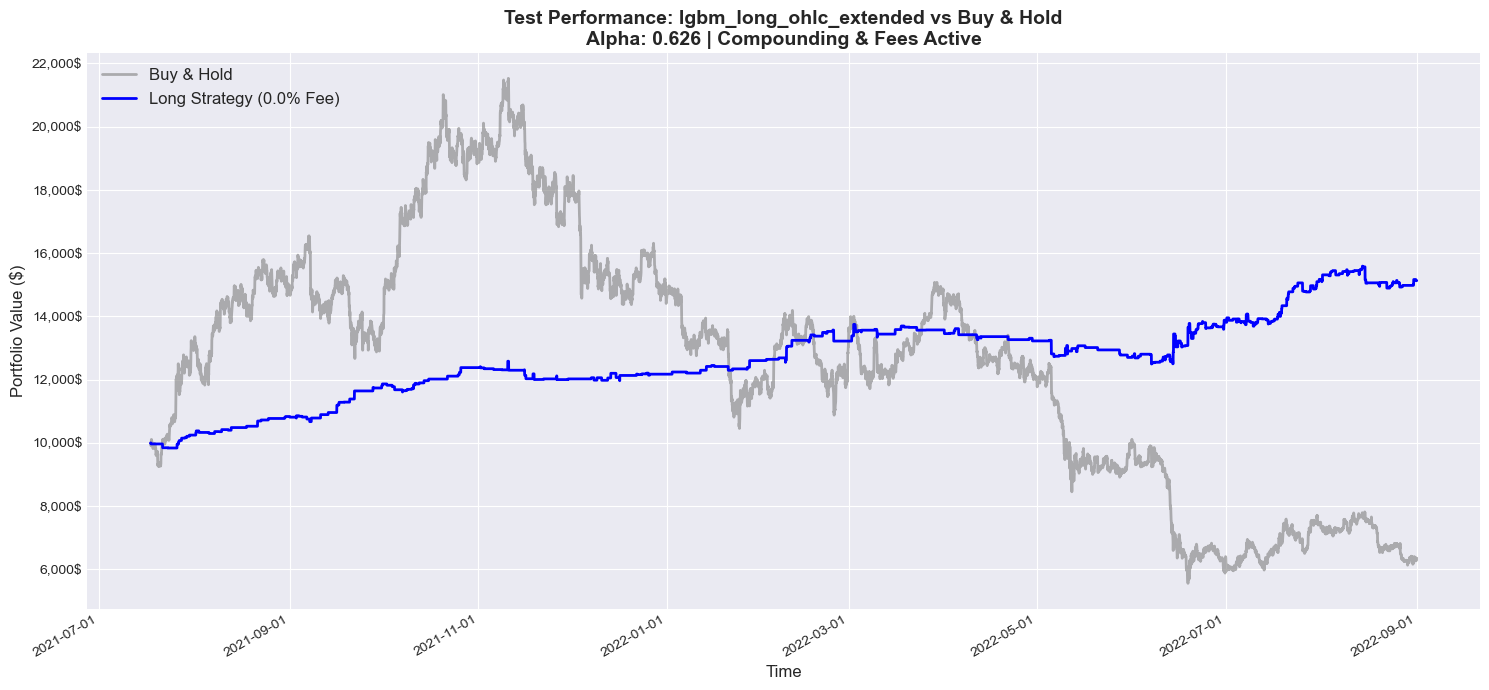

--------------------------------------------------
Initial Capital:         $10,000.00
Buy & Hold Final Value:  $6,321.51 (-36.78%)
Strategy Final Value:    $15,131.33 (51.31%)
Total signals generated: 383 (out of 9248 steps)
Total trades executed:   676
--------------------------------------------------


In [39]:
plot_strategy_performance(
    df=df, 
    test_sl=test_sl, 
    cfg=cfg, 
    probs=probs, 
    alpha=alpha, 
    r_test=r_test, 
    strategy=strategy, 
    tag=TAG,
    fee_rate=0.000
)

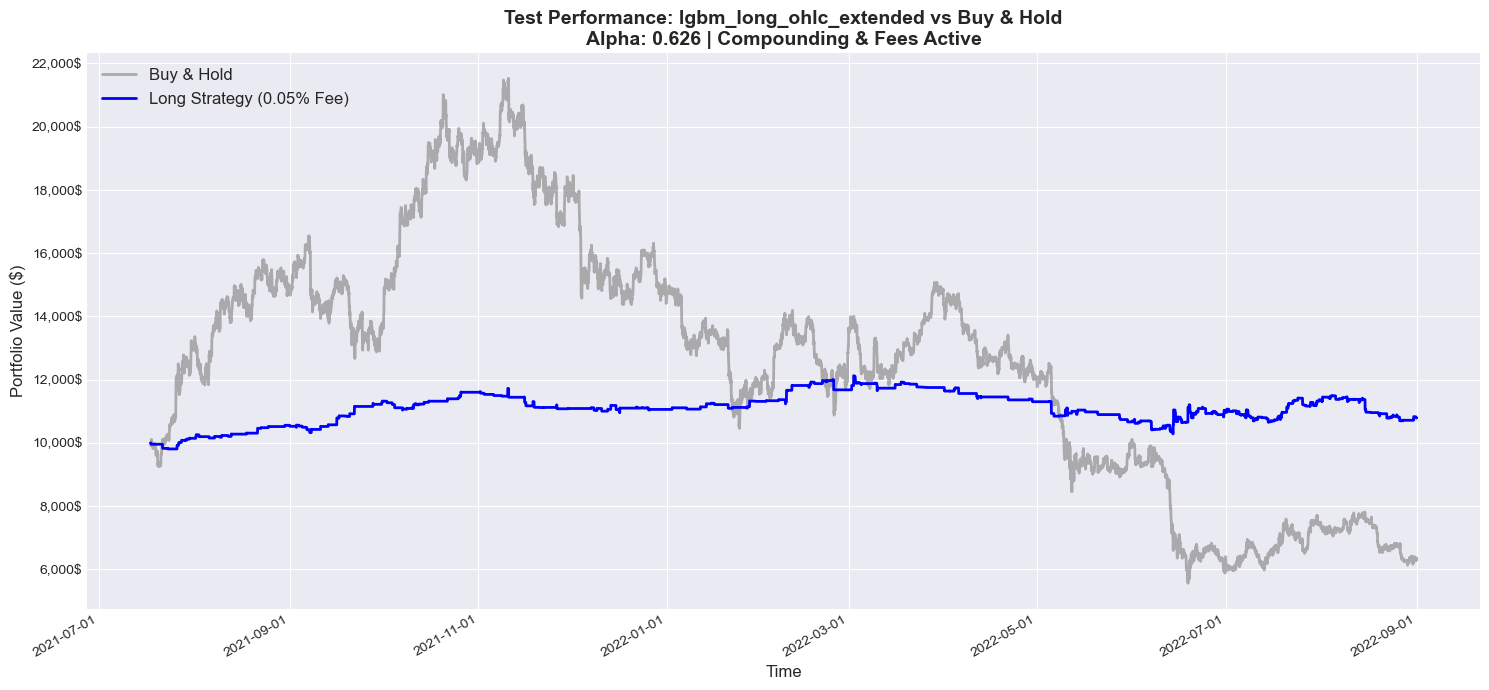

--------------------------------------------------
Initial Capital:         $10,000.00
Buy & Hold Final Value:  $6,321.51 (-36.78%)
Strategy Final Value:    $10,790.68 (7.91%)
Total signals generated: 383 (out of 9248 steps)
Total trades executed:   676
--------------------------------------------------


In [40]:
plot_strategy_performance(
    df=df, 
    test_sl=test_sl, 
    cfg=cfg, 
    probs=probs, 
    alpha=alpha, 
    r_test=r_test, 
    strategy=strategy, 
    tag=TAG,
    fee_rate=0.0005
)